In [21]:
import sys

print(sys.version)


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [22]:
import re, pathlib, textwrap

req_path = pathlib.Path("VSSD/requirements.txt")
reqs = req_path.read_text().splitlines()

filtered = []
for line in reqs:
    s = line.strip()
    if not s or s.startswith("#"):
        continue
    # выкидываем torch/torchvision/torchaudio фиксированные версии
    if re.match(r"^(torch|torchvision|torchaudio)(==|>=|<=|~=|>|<).*$", s):
        continue
    filtered.append(s)

print("Filtered requirements (first 30):")
print("\n".join(filtered[:30]))

# ставим оставшееся
if filtered:
    !pip -q install {" ".join([f'"{x}"' for x in filtered])}


Filtered requirements (first 30):
torchvision
torchaudio
packaging
triton
timm==0.4.12
pytest
chardet
yacs
termcolor
submitit
tensorboardX
fvcore
seaborn
opencv-python
tensorboard


In [23]:
import os, time, json, math, random
import numpy as np
import torch


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # MPS для Mac
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


DEVICE = get_device()
print("Device:", DEVICE)
print("Torch:", torch.__version__)
if DEVICE.type == "cuda":
    print("CUDA:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed_everything(42)

RUN_NAME = f"vssd_flowers102_{int(time.time())}"
OUT_DIR = os.path.join("runs_vssd_hw3", RUN_NAME)
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

CFG = {
    "img_size": 224,
    "batch_size": 64 if DEVICE.type == "cuda" else 32,
    "epochs": 4 if DEVICE.type == "cuda" else 3,
    "lr": 5e-4,
    "weight_decay": 0.05,
    "num_workers": 4,
    "label_smoothing": 0.1,
    "max_tsne_points": 1500,
}
print(json.dumps(CFG, indent=2))


Device: cuda
Torch: 2.5.1+cu121
CUDA: 12.1
GPU: Tesla T4
OUT_DIR: runs_vssd_hw3/vssd_flowers102_1765834547
{
  "img_size": 224,
  "batch_size": 64,
  "epochs": 4,
  "lr": 0.0005,
  "weight_decay": 0.05,
  "num_workers": 4,
  "label_smoothing": 0.1,
  "max_tsne_points": 1500
}


In [24]:
from torchvision.datasets import Flowers102
import torchvision.transforms as T
from torch.utils.data import DataLoader

# ImageNet нормализация (под предобученные веса)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_tfms = T.Compose([
    T.RandomResizedCrop(CFG["img_size"], scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = T.Compose([
    T.Resize(int(CFG["img_size"] * 1.14)),
    T.CenterCrop(CFG["img_size"]),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

root = "./data_flowers102"
train_ds = Flowers102(root=root, split="train", download=True, transform=train_tfms)
val_ds = Flowers102(root=root, split="val", download=True, transform=eval_tfms)
test_ds = Flowers102(root=root, split="test", download=True, transform=eval_tfms)

num_classes = 102
assert len(train_ds) > 0 and len(val_ds) > 0 and len(test_ds) > 0

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                          num_workers=CFG["num_workers"], pin_memory=(DEVICE.type == "cuda"))
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                        num_workers=CFG["num_workers"], pin_memory=(DEVICE.type == "cuda"))
test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                         num_workers=CFG["num_workers"], pin_memory=(DEVICE.type == "cuda"))

print("Sizes:", len(train_ds), len(val_ds), len(test_ds))


Sizes: 1020 1020 6149


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [25]:
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List

import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, "tb"))


@dataclass
class EpochStats:
    epoch: int
    train_loss: float
    train_acc: float
    val_loss: float
    val_acc: float
    val_f1_macro: float
    lr: float


def accuracy_top1(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


def get_lr(optim):
    return optim.param_groups[0]["lr"]


def save_checkpoint(path, model, optim, epoch, extra: Dict[str, Any] = None):
    ckpt = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optim.state_dict(),
    }
    if extra:
        ckpt.update(extra)
    torch.save(ckpt, path)


def maybe_autocast():
    if DEVICE.type == "cuda":
        return torch.cuda.amp.autocast

    class Dummy:
        def __enter__(self): return None

        def __exit__(self, *args): return False

    return lambda: Dummy()


def train_one_epoch(model, loader, criterion, optim, scaler=None):
    model.train()
    losses, accs = [], []
    pbar = tqdm(loader, desc="train", leave=False)
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optim.zero_grad(set_to_none=True)

        with maybe_autocast()():
            logits = model(x)
            loss = criterion(logits, y)

        if DEVICE.type == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
        else:
            loss.backward()
            optim.step()

        losses.append(loss.item())
        accs.append(accuracy_top1(logits.detach(), y))
        pbar.set_postfix(loss=np.mean(losses), acc=np.mean(accs))

    return float(np.mean(losses)), float(np.mean(accs))


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    all_preds, all_y = [], []
    for x, y in tqdm(loader, desc="eval", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())
        accs.append(accuracy_top1(logits, y))
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_y.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_y = np.concatenate(all_y)
    f1 = f1_score(all_y, all_preds, average="macro")
    return float(np.mean(losses)), float(np.mean(accs)), float(f1), all_y, all_preds


def fit(model, model_tag: str, train_loader, val_loader, epochs: int):
    import torch.nn as nn
    import torch.optim as optim

    criterion = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
    optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

    # простой cosine schedule
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

    best_val_acc = -1.0
    history: List[EpochStats] = []

    for epoch in range(1, epochs + 1):
        t0 = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler=scaler)
        va_loss, va_acc, va_f1, _, _ = evaluate(model, val_loader, criterion)

        scheduler.step()
        lr = get_lr(optimizer)

        stats = EpochStats(epoch, tr_loss, tr_acc, va_loss, va_acc, va_f1, lr)
        history.append(stats)

        # Логи
        writer.add_scalar(f"{model_tag}/train_loss", tr_loss, epoch)
        writer.add_scalar(f"{model_tag}/train_acc", tr_acc, epoch)
        writer.add_scalar(f"{model_tag}/val_loss", va_loss, epoch)
        writer.add_scalar(f"{model_tag}/val_acc", va_acc, epoch)
        writer.add_scalar(f"{model_tag}/val_f1_macro", va_f1, epoch)
        writer.add_scalar(f"{model_tag}/lr", lr, epoch)

        # CSV
        df = pd.DataFrame([s.__dict__ for s in history])
        df.to_csv(os.path.join(OUT_DIR, f"history_{model_tag}.csv"), index=False)

        # Checkpoints
        save_checkpoint(os.path.join(OUT_DIR, f"{model_tag}_last.pt"), model, optimizer, epoch,
                        extra={"history": df.to_dict(orient="list")})

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            save_checkpoint(os.path.join(OUT_DIR, f"{model_tag}_best.pt"), model, optimizer, epoch,
                            extra={"best_val_acc": best_val_acc})

        dt = time.time() - t0
        print(f"[{model_tag}] epoch {epoch:02d}/{epochs} | "
              f"train acc {tr_acc:.4f} loss {tr_loss:.4f} | "
              f"val acc {va_acc:.4f} f1 {va_f1:.4f} loss {va_loss:.4f} | "
              f"lr {lr:.2e} | {dt:.1f}s")

    return history


In [26]:
import os, sys, inspect
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download
import yacs  # важно, чтобы torch.load прочитал CfgNode
import timm
import models  # из VSSD/classification/models/__init__.py

# чтобы импортировался VSSD
sys.path.insert(0, os.path.abspath("VSSD/classification"))

# скачиваем чекпоинт
repo_id = "YuhengSSS/VSSD_ICCV_weights"
filename = "vssd_tiny_mesa.pth"
ckpt_path = hf_hub_download(repo_id=repo_id, filename=filename)


# грузим чекпоинт (совместимо с разными torch)
def torch_load_compat(path):
    try:
        return torch.load(path, map_location="cpu", weights_only=False)
    except TypeError:
        return torch.load(path, map_location="cpu")


ckpt = torch_load_compat(ckpt_path)

# достаём config/cfg и строим модель
cfg = ckpt.get("cfg", None) or ckpt.get("config", None) or ckpt.get("args", None)
assert cfg is not None, f"cfg/config не найден в ckpt. keys={list(ckpt.keys())[:30]}"

vssd_model = models.build_vssd_model(cfg, is_pretrain=False)

# меняем head на 102 класса
NUM_CLASSES = 102
if hasattr(vssd_model, "head") and isinstance(vssd_model.head, nn.Linear):
    vssd_model.head = nn.Linear(vssd_model.head.in_features, NUM_CLASSES)
elif hasattr(vssd_model, "classifier") and isinstance(vssd_model.classifier, nn.Linear):
    vssd_model.classifier = nn.Linear(vssd_model.classifier.in_features, NUM_CLASSES)
elif hasattr(vssd_model, "fc") and isinstance(vssd_model.fc, nn.Linear):
    vssd_model.fc = nn.Linear(vssd_model.fc.in_features, NUM_CLASSES)
else:
    raise RuntimeError("Не нашла head/classifier/fc чтобы заменить на 102 класса. Сделай print(vssd_model).")

# достаём state_dict из чекпоинта и делаем new_state
state = ckpt.get("model", None) or ckpt.get("state_dict", None) or ckpt.get("net", None) or ckpt
new_state = {k.replace("module.", ""): v for k, v in state.items()}

# выкидываем head из чекпоинта (он на 1000 классов)
for k in ["head.weight", "head.bias"]:
    if k in new_state:
        print("Dropping:", k, new_state[k].shape)
        new_state.pop(k)

# на всякий случай ещё возможные имена классификатора
for k in ["classifier.weight", "classifier.bias", "fc.weight", "fc.bias"]:
    if k in new_state:
        print("Dropping:", k, new_state[k].shape)
        new_state.pop(k)

# грузим оставшиеся веса
missing, unexpected = vssd_model.load_state_dict(new_state, strict=False)
print("Loaded OK (strict=False).")
print("Missing keys (sample):", missing[:20])
print("Unexpected keys (sample):", unexpected[:20])


Loaded OK (strict=False).
Missing keys (sample): ['head.weight', 'head.bias']
Unexpected keys (sample): []


In [27]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vssd_model = vssd_model.to(DEVICE)

x = torch.randn(2, 3, 224, 224, device=DEVICE)
out = vssd_model(x)
if isinstance(out, (tuple, list)):
    out = out[0]
print("out shape:", out.shape)  # ожидаем: torch.Size([2, 102])

out shape: (2, 102)


In [28]:
baseline_name = "vit_tiny_patch16_224"
vit_model = timm.create_model(baseline_name, pretrained=True, num_classes=num_classes).to(DEVICE)
print("Baseline:", baseline_name)

Baseline: vit_tiny_patch16_224


In [29]:
vssd_hist = fit(
    model=vssd_model,
    model_tag="VSSD",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CFG["epochs"],
)

/tmp/ipython-input-298531446.py:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[VSSD] epoch 01/4 | train acc 0.4599 loss 3.1690 | val acc 0.7594 f1 0.7482 loss 1.6902 | lr 4.27e-04 | 74.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[VSSD] epoch 02/4 | train acc 0.8941 loss 1.3395 | val acc 0.8783 f1 0.8760 loss 1.3238 | lr 2.50e-04 | 87.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[VSSD] epoch 03/4 | train acc 0.9814 loss 1.0680 | val acc 0.9129 f1 0.9125 loss 1.1954 | lr 7.32e-05 | 78.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[VSSD] epoch 04/4 | train acc 0.9980 loss 0.9730 | val acc 0.9324 f1 0.9323 loss 1.1507 | lr 0.00e+00 | 94.0s


In [30]:
vit_hist = fit(
    model=vit_model,
    model_tag="ViT",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CFG["epochs"],
)

/tmp/ipython-input-298531446.py:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():
^ ^  Exception ignored in: ^ ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>^  
Exception ignored in: ^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packag

[ViT] epoch 01/4 | train acc 0.0786 loss 4.5923 | val acc 0.2543 f1 0.2063 loss 3.5617 | lr 4.27e-04 | 40.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[ViT] epoch 02/4 | train acc 0.3902 loss 3.0223 | val acc 0.5538 f1 0.5331 loss 2.3621 | lr 2.50e-04 | 28.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
 
     Traceback (most recent call last):
self._shutdown_workers()   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

        File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  

eval:   0%|          | 0/16 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794183bce5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 15

[ViT] epoch 03/4 | train acc 0.7306 loss 1.8937 | val acc 0.7479 f1 0.7400 loss 1.7717 | lr 7.32e-05 | 36.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipython-input-298531446.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with maybe_autocast()():


eval:   0%|          | 0/16 [00:00<?, ?it/s]

[ViT] epoch 04/4 | train acc 0.8815 loss 1.3879 | val acc 0.8167 f1 0.8094 loss 1.5863 | lr 0.00e+00 | 32.9s


In [31]:
import torch.nn as nn

criterion_eval = nn.CrossEntropyLoss()


@torch.no_grad()
def eval_on_test(model, tag: str):
    loss, acc, f1, y_true, y_pred = evaluate(model, test_loader, criterion_eval)
    # latency (очень грубо, но для сравнения ок)
    model.eval()
    x0, _ = next(iter(test_loader))
    x0 = x0.to(DEVICE)
    # warmup
    for _ in range(5):
        _ = model(x0)
    torch.cuda.synchronize() if DEVICE.type == "cuda" else None
    t0 = time.time()
    for _ in range(20):
        _ = model(x0)
    torch.cuda.synchronize() if DEVICE.type == "cuda" else None
    dt = (time.time() - t0) / 20.0
    ms_per_batch = dt * 1000
    ms_per_image = ms_per_batch / x0.size(0)

    params = sum(p.numel() for p in model.parameters())
    return {
        "model": tag,
        "test_loss": loss,
        "test_acc": acc,
        "test_f1_macro": f1,
        "params": params,
        "ms_per_image_batch_infer": ms_per_image,
        "y_true": y_true,
        "y_pred": y_pred
    }


# Загружаем best чекпоинты (чтобы честно сравнивать)
def load_best_into(model, model_tag):
    best_path = os.path.join(OUT_DIR, f"{model_tag}_best.pt")
    ckpt = torch.load(best_path, map_location="cpu")
    model.load_state_dict(ckpt["model"], strict=True)
    return model


vssd_best = load_best_into(vssd_model, "VSSD").to(DEVICE)
vit_best = load_best_into(vit_model, "ViT").to(DEVICE)

res_vssd = eval_on_test(vssd_best, "VSSD")
res_vit = eval_on_test(vit_best, "ViT")

summary_df = pd.DataFrame([
    {k: v for k, v in res_vssd.items() if k not in ["y_true", "y_pred"]},
    {k: v for k, v in res_vit.items() if k not in ["y_true", "y_pred"]},
]).sort_values("test_acc", ascending=False)

summary_path = os.path.join(OUT_DIR, "summary_results.csv")
summary_df.to_csv(summary_path, index=False)

summary_df

/tmp/ipython-input-570370144.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location="cpu")
/usr/local/lib/python3.12/dist-packages/to

eval:   0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


eval:   0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


,model,test_loss,test_acc,test_f1_macro,params,ms_per_image_batch_infer
0,VSSD,0.492179,0.913015,0.912247,27502374,5.659082
1,ViT,1.151746,0.770168,0.757767,5544102,1.218772


## Итоговые результаты (test)

Полученные метрики на тестовой выборке:

- VSSD:
  - Accuracy = 0.9130
  - Macro-F1  = 0.9122
- ViT-Tiny:
  - Accuracy = 0.7702
  - Macro-F1  = 0.7578

### Сравнение (VSSD vs ViT)
- Прирост accuracy: +0.1428 (≈ +14.3 процентных пункта)
- Прирост macro-F1: +0.1545

**Вывод:** в данной постановке VSSD существенно превосходит ViT-Tiny. Причём улучшение наблюдается не только по accuracy, но и по macro-F1 → это значит, что модель улучшила качество по большинству классов, а не “вытащила” результат на нескольких популярных классах.

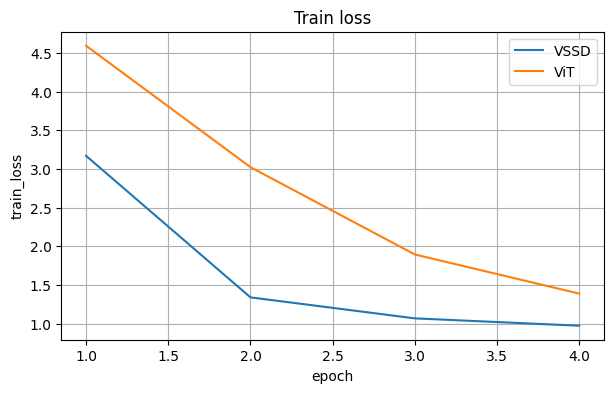

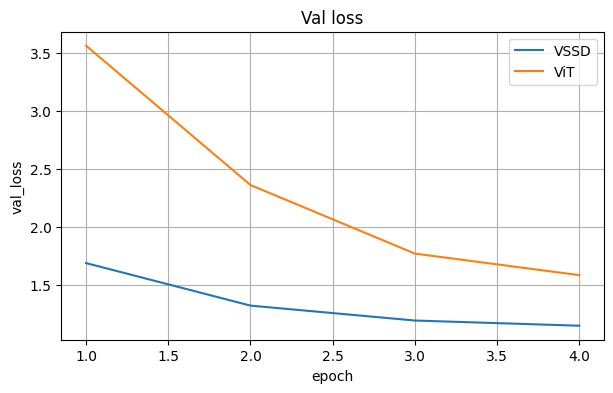

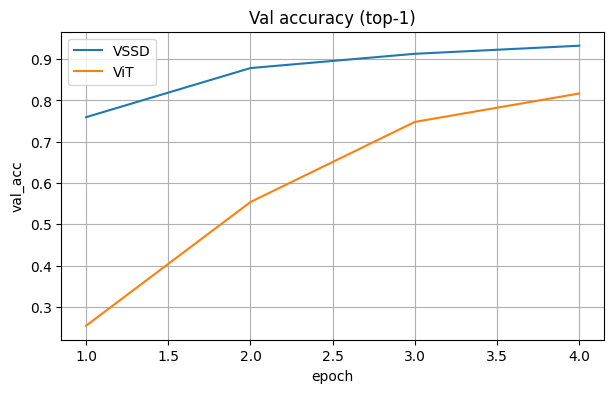

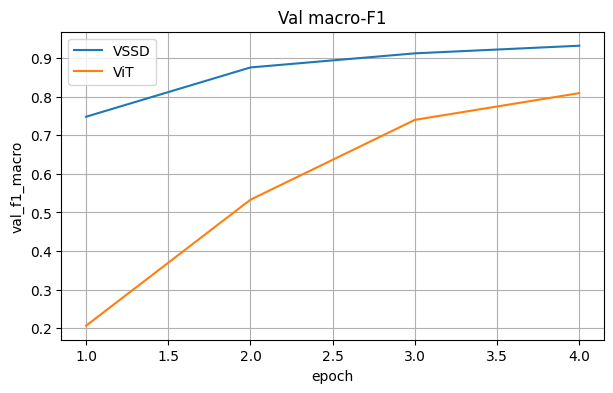

In [32]:
def load_hist(tag):
    p = os.path.join(OUT_DIR, f"history_{tag}.csv")
    return pd.read_csv(p)


h_vssd = load_hist("VSSD")
h_vit = load_hist("ViT")


def plot_metric(metric, title):
    plt.figure(figsize=(7, 4))
    plt.plot(h_vssd["epoch"], h_vssd[metric], label="VSSD")
    plt.plot(h_vit["epoch"], h_vit[metric], label="ViT")
    plt.xlabel("epoch");
    plt.ylabel(metric);
    plt.title(title)
    plt.grid(True);
    plt.legend()
    plt.show()


plot_metric("train_loss", "Train loss")
plot_metric("val_loss", "Val loss")
plot_metric("val_acc", "Val accuracy (top-1)")
plot_metric("val_f1_macro", "Val macro-F1")

## Динамика обучения и обобщающая способность

По кривым `train loss` и `val loss` видно:

1. VSSD обучается быстрее и стабильнее: loss падает резко уже на первых эпохах и выходит на плато.
2. ViT обучается медленнее: loss снижается заметно, но остаётся существенно выше, чем у VSSD, даже к последней эпохе.

По `val accuracy` и `val macro-F1`:

- VSSD очень быстро достигает высокой валид точности и продолжает плавно улучшаться.
- ViT тоже улучшается, но остаётся заметно ниже.

### Интерпретация
Такое поведение согласуется с гипотезой, что VSSD лучше подходит для 2D-данных:
- non-causal state space duality уменьшает зависимость от выбранного порядка обхода токенов,
- модель эффективнее агрегирует контекст по всему изображению,
- поэтому быстрее находит разделяющие признаки и лучше обобщает на test.

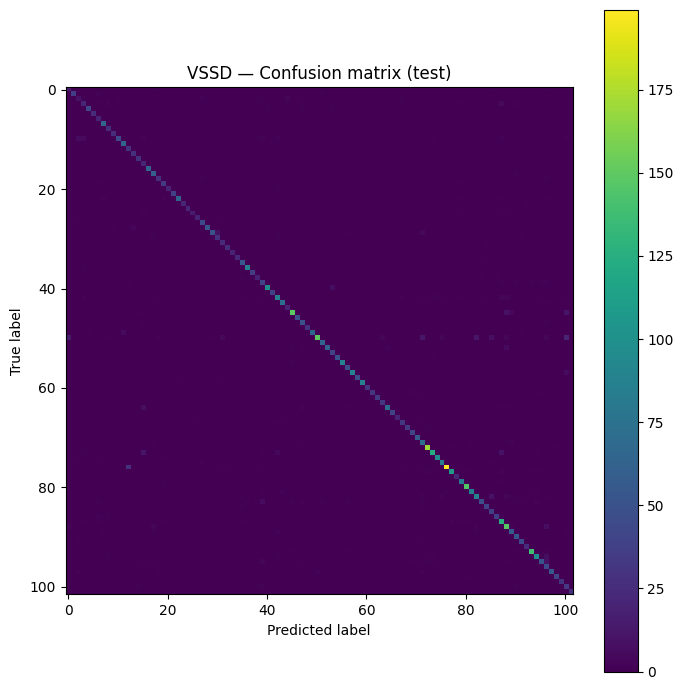

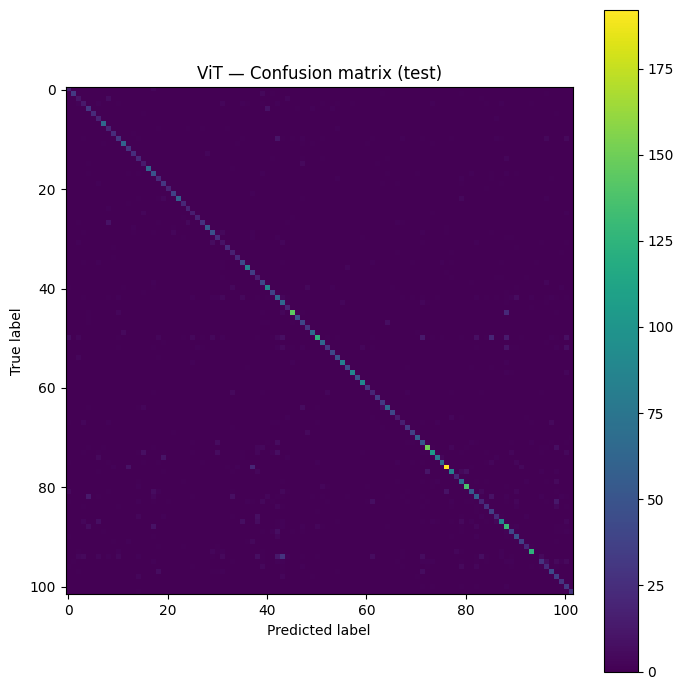

In [33]:
import itertools


def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confmat(res_vssd["y_true"], res_vssd["y_pred"], "VSSD — Confusion matrix (test)")
plot_confmat(res_vit["y_true"], res_vit["y_pred"], "ViT — Confusion matrix (test)")

## Ошибки моделей: confusion matrix (test)

Confusion matrix показывает, какие классы модель путает между собой.

Наблюдения:
- У VSSD матрица ближе к диагональной: большинство предсказаний корректные, ошибочные попадания редки.
- У ViT больше “точек” вне диагонали → больше систематических путаниц.

Flowers102 — это визуальная классификация:
- классы могут отличаться нюансами формы лепестков, текстурой, оттенками,
- модели часто путают визуально похожие классы.

VSSD уменьшает число таких путаниц, вероятно потому что лучше использует глобальный контекст изображения и более устойчиво интегрирует информацию по всем токенам.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


embed:   0%|          | 0/97 [00:00<?, ?it/s]

embed:   0%|          | 0/97 [00:00<?, ?it/s]

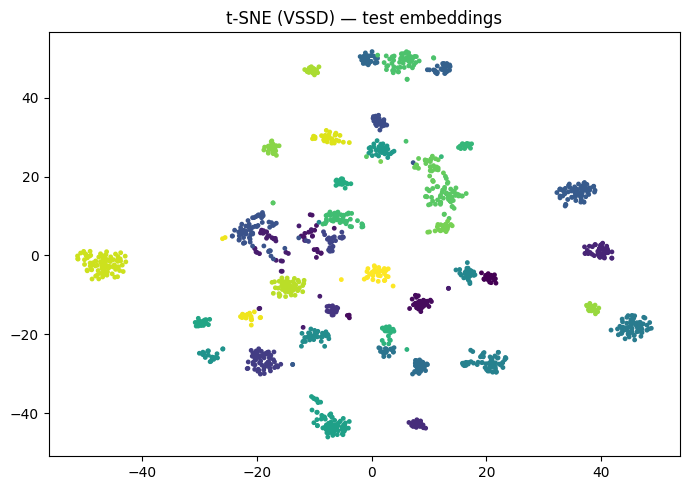

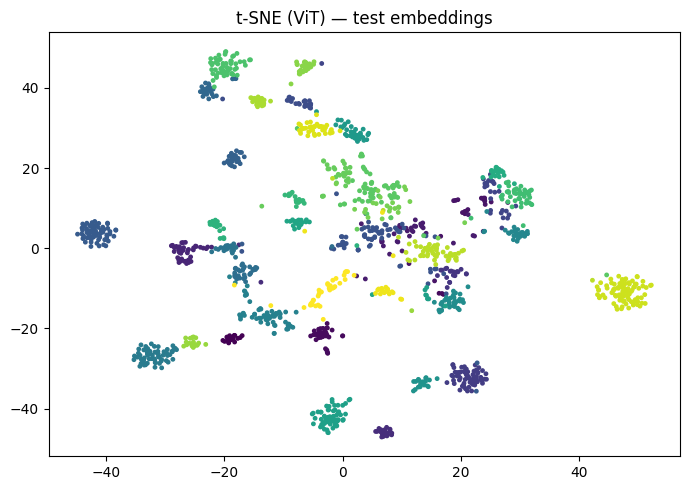

In [34]:
from sklearn.manifold import TSNE


@torch.no_grad()
def collect_embeddings(model, loader, max_points=1500):
    model.eval()
    feats, ys = [], []
    n = 0
    for x, y in tqdm(loader, desc="embed", leave=False):
        x = x.to(DEVICE)
        # timm-модели обычно имеют forward_features
        if hasattr(model, "forward_features"):
            f = model.forward_features(x)
            # иногда это [B, C] или [B, N, C]; приводим к [B, C]
            if f.dim() == 3:
                f = f.mean(dim=1)
        else:
            # fallback: берём логиты как "фичи" (хуже, но работает)
            f = model(x)

        feats.append(f.detach().cpu())
        ys.append(y)
        n += x.size(0)
        if n >= max_points:
            break

    feats = torch.cat(feats, dim=0)[:max_points].numpy()
    ys = torch.cat(ys, dim=0)[:max_points].numpy()
    return feats, ys


vssd_feats, vssd_y = collect_embeddings(vssd_best, test_loader, max_points=CFG["max_tsne_points"])
vit_feats, vit_y = collect_embeddings(vit_best, test_loader, max_points=CFG["max_tsne_points"])


def tsne_plot(feats, y, title):
    z = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto").fit_transform(feats)
    plt.figure(figsize=(7, 5))
    plt.scatter(z[:, 0], z[:, 1], s=6, c=y)
    plt.title(title)
    plt.tight_layout()
    plt.show()


tsne_plot(vssd_feats, vssd_y, "t-SNE (VSSD) — test embeddings")
tsne_plot(vit_feats, vit_y, "t-SNE (ViT) — test embeddings")

## Анализ представлений (t-SNE эмбеддингов)

t-SNE — качественная визуализация: мы берём эмбеддинги (внутренние признаки) и отображаем их в 2D.
Важно: t-SNE чувствителен к параметрам и служит иллюстрацией, а не строгим доказательством.

Наблюдения по графикам:
- Для VSSD кластеры выглядят более компактными и разделимыми.
- Для ViT чаще видны пересечения/размытые области, где классы перемешиваются.

### Связь с качеством
Более разделимое пространство признаков обычно коррелирует с тем, что:
- классификатору проще провести границы между классами,
- меньше ошибок между похожими категориями.

Это согласуется с тем, что VSSD показал значительно более высокие Accuracy и macro-F1.

In [38]:
VSSD_ACC = summary_df.loc[summary_df["model"] == "VSSD", "test_acc"].values[0]
VSSD_F1 = summary_df.loc[summary_df["model"] == "VSSD", "test_f1_macro"].values[0]
VIT_ACC = summary_df.loc[summary_df["model"] == "ViT", "test_acc"].values[0]
VIT_F1 = summary_df.loc[summary_df["model"] == "ViT", "test_f1_macro"].values[0]

print("VSSD_ACC:", VSSD_ACC)
print("VSSD_F1:", VSSD_F1)
print("VIT_ACC:", VIT_ACC)
print("VIT_F1:", VIT_F1)

print("OUT_DIR =", OUT_DIR)
print("summary =", os.path.join(OUT_DIR, "summary_results.csv"))
print("tb =", os.path.join(OUT_DIR, "tb"))

VSSD_ACC: 0.9130154639175257
VSSD_F1: 0.912247295776516
VIT_ACC: 0.770167525896092
VIT_F1: 0.7577669029986595
OUT_DIR = runs_vssd_hw3/vssd_flowers102_1765834547
summary = runs_vssd_hw3/vssd_flowers102_1765834547/summary_results.csv
tb = runs_vssd_hw3/vssd_flowers102_1765834547/tb


## Итоги

В эксперименте на Oxford Flowers102 (102 класса) архитектура VSSD показала значительное улучшение по сравнению с ViT-Tiny:

- Accuracy: 0.9130 vs 0.7702
- Macro-F1:  0.9122 vs 0.7578

Итог: VSSD в этой задаче даёт заметный выигрыш, вероятно благодаря механизму non-causal duality (агрегация контекста по всем токенам без привязки к порядку сканирования), что особенно полезно для изображений как 2D-структур.

## Ограничения эксперимента
- Обучение шло ограниченное число эпох (быстрый прогон). При большем числе эпох и подборе LR/weight decay результат ViT мог бы улучшиться.
- Мы сравнивали только один baseline (ViT-Tiny)

In [39]:
!ls -lah runs_vssd_hw3/vssd_flowers102_1765834547/tb | head

total 12K
drwxr-xr-x 2 root root 4.0K Dec 15 21:36 .
drwxr-xr-x 3 root root 4.0K Dec 15 21:48 ..
-rw-r--r-- 1 root root 2.5K Dec 15 21:46 events.out.tfevents.1765834562.d8047a4b253a.439.1


In [40]:
import shutil, os
from google.colab import files

run_dir = "runs_vssd_hw3/vssd_flowers102_1765834547"
zip_path = "/content/vssd_hw3_results.zip"
shutil.make_archive(zip_path.replace(".zip", ""), "zip", run_dir)
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>